In [1]:
# ==============================================================
# 🩺 GastroVision Dataset Loader (Clean + Fast Version)
# ==============================================================

import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set base path to your Kaggle dataset
BASE_DIR = "/kaggle/input/gastrovision-gastrointestinal-disease-detection/Gastrovision"

# Clean up TensorFlow logs for a tidy output
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
os.environ["TF_ENABLE_ONEDNN_OPTS"] = "0"

import tensorflow as tf
tf.config.threading.set_intra_op_parallelism_threads(1)
tf.config.threading.set_inter_op_parallelism_threads(1)

# Function to create train/validation generators
def get_data_generators(base_dir=BASE_DIR, img_size=(224,224), batch_size=32, val_split=0.2):
    datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=15,
        horizontal_flip=True,
        zoom_range=0.2,
        validation_split=val_split
    )

    train = datagen.flow_from_directory(
        base_dir,
        target_size=img_size,
        batch_size=batch_size,
        class_mode="categorical",
        subset="training",
        shuffle=True
    )

    val = datagen.flow_from_directory(
        base_dir,
        target_size=img_size,
        batch_size=batch_size,
        class_mode="categorical",
        subset="validation",
        shuffle=False
    )

    print(f"\n✅ Data Loaded Successfully!")
    print(f"Training images: {train.samples}")
    print(f"Validation images: {val.samples}")
    print(f"Classes detected: {len(train.class_indices)}\n")

    return train, val

# Run the loader
train_gen, val_gen = get_data_generators()


2025-11-08 08:10:38.735798: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762589438.945326      48 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762589439.021122      48 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

Found 6408 images belonging to 27 classes.
Found 1592 images belonging to 27 classes.

✅ Data Loaded Successfully!
Training images: 6408
Validation images: 1592
Classes detected: 27



In [2]:
# ==============================================================
# 🧠 Model: EfficientNetB0 (Transfer Learning)
# ==============================================================

from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam

def build_model(num_classes):
    # use randomly initialized weights (no internet needed)
    base_model = EfficientNetB0(weights=None, include_top=False, input_shape=(224,224,3))
    
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dropout(0.4)(x)
    output = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=base_model.input, outputs=output)

    model.compile(optimizer=Adam(1e-4),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Create and compile model
model = build_model(num_classes=len(train_gen.class_indices))
model.summary()


I0000 00:00:1762589468.130005      48 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1762589468.130625      48 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ normalization[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_bn  │ (None, 112, 112,  │         64 │ block1a_project_

 Total params: 4,084,158 (15.58 MB)

 Trainable params: 4,042,135 (15.42 MB)

 Non-trainable params: 42,023 (164.16 KB)

In [3]:
# ==============================================================
# 🚀 Train the Model
# ==============================================================

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    verbose=1
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10


I0000 00:00:1762589593.358704     121 service.cc:148] XLA service 0x7c6c4c01aa20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1762589593.359657     121 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1762589593.359679     121 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1762589598.658415     121 cuda_dnn.cc:529] Loaded cuDNN version 90300
E0000 00:00:1762589609.038766     121 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1762589609.181959     121 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1762589609.640901     121 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. Th

 57/201 ━━━━━━━━━━━━━━━━━━━━ 1:51 772ms/step - accuracy: 0.1583 - loss: 3.1059

E0000 00:00:1762589686.260775     121 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1762589686.396806     121 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


201/201 ━━━━━━━━━━━━━━━━━━━━ 318s 1s/step - accuracy: 0.2239 - loss: 2.7886 - val_accuracy: 0.1212 - val_loss: 3.7076
Epoch 2/10
201/201 ━━━━━━━━━━━━━━━━━━━━ 132s 655ms/step - accuracy: 0.3609 - loss: 2.0974 - val_accuracy: 0.1212 - val_loss: 4.1730
Epoch 3/10
201/201 ━━━━━━━━━━━━━━━━━━━━ 130s 645ms/step - accuracy: 0.3979 - loss: 1.9314 - val_accuracy: 0.1244 - val_loss: 3.7086
Epoch 4/10
201/201 ━━━━━━━━━━━━━━━━━━━━ 129s 643ms/step - accuracy: 0.4380 - loss: 1.7919 - val_accuracy: 0.4001 - val_loss: 1.9454
Epoch 5/10
201/201 ━━━━━━━━━━━━━━━━━━━━ 129s 642ms/step - accuracy: 0.4657 - loss: 1.7290 - val_accuracy: 0.4667 - val_loss: 1.6657
Epoch 6/10
201/201 ━━━━━━━━━━━━━━━━━━━━ 130s 646ms/step - accuracy: 0.4783 - loss: 1.6511 - val_accuracy: 0.4780 - val_loss: 1.6728
Epoch 7/10
201/201 ━━━━━━━━━━━━━━━━━━━━ 132s 656ms/step - accuracy: 0.4878 - loss: 1.6236 - val_accuracy: 0.4830 - val_loss: 1.5887
Epoch 8/10
201/201 ━━━━━━━━━━━━━━━━━━━━ 137s 679ms/step - accuracy: 0.5052 - loss: 1.5891 

50/50 ━━━━━━━━━━━━━━━━━━━━ 25s 495ms/step - accuracy: 0.5137 - loss: 1.4566

✅ Validation Accuracy: 52.51%
📉 Validation Loss: 1.4446
50/50 ━━━━━━━━━━━━━━━━━━━━ 36s 599ms/step

📊 Classification Metrics Summary:


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,precision,recall,f1-score,support
Accessory tools,0.768293,0.747036,0.757515,253.000000
Angiectasia,0.000000,0.000000,0.000000,3.000000
Barretts esophagus,0.000000,0.000000,0.000000,19.000000
Blood in lumen,0.600000,0.088235,0.153846,34.000000
Cecum,0.000000,0.000000,0.000000,22.000000
Colon diverticula,0.000000,0.000000,0.000000,5.000000
Colon polyps,0.352113,0.152439,0.212766,164.000000
Colorectal cancer,0.000000,0.000000,0.000000,27.000000
Duodenal bulb,0.000000,0.000000,0.000000,41.000000
Dyed-lifted-polyps,0.500000,0.107143,0.176471,28.000000


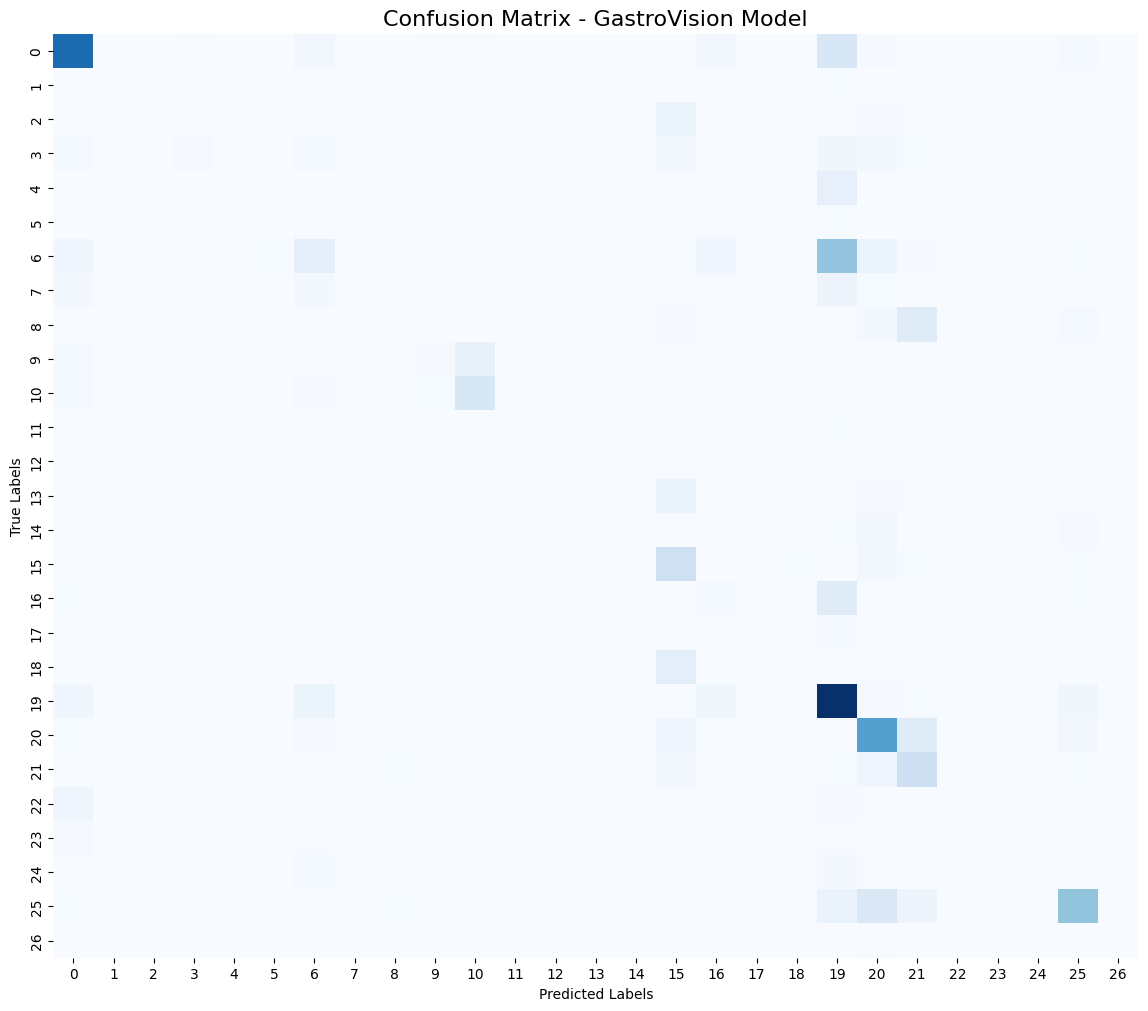


💾 Model saved successfully to /kaggle/working/gastrovision_model.h5

🔍 Final Summary:
   Accuracy : 52.51%
   Precision: 21.60%
   Recall   : 20.82%
   F1-score : 18.78%


In [4]:
# ==============================================================
# 📊 Evaluate, Report Metrics & Save Model
# ==============================================================

import numpy as np
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1️⃣ Evaluate model on validation set ---
val_loss, val_acc = model.evaluate(val_gen, verbose=1)
print(f"\n✅ Validation Accuracy: {val_acc:.2%}")
print(f"📉 Validation Loss: {val_loss:.4f}")

# --- 2️⃣ Predict on validation data ---
val_gen.reset()
predictions = model.predict(val_gen, verbose=1)
y_pred = np.argmax(predictions, axis=1)
y_true = val_gen.classes
class_labels = list(val_gen.class_indices.keys())

# --- 3️⃣ Classification Report ---
report = classification_report(
    y_true, y_pred, target_names=class_labels, output_dict=True
)
df_report = pd.DataFrame(report).transpose()

print("\n📊 Classification Metrics Summary:")
display(df_report[['precision', 'recall', 'f1-score', 'support']])

# --- 4️⃣ Confusion Matrix Visualization ---
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(14, 12))
sns.heatmap(cm, cmap="Blues", cbar=False)
plt.title("Confusion Matrix - GastroVision Model", fontsize=16)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

# --- 5️⃣ Save the Model ---
model.save("/kaggle/working/gastrovision_model.h5")
print("\n💾 Model saved successfully to /kaggle/working/gastrovision_model.h5")

# --- 6️⃣ Summary Metrics ---
macro_precision = df_report.loc["macro avg", "precision"]
macro_recall = df_report.loc["macro avg", "recall"]
macro_f1 = df_report.loc["macro avg", "f1-score"]

print("\n🔍 Final Summary:")
print(f"   Accuracy : {val_acc:.2%}")
print(f"   Precision: {macro_precision:.2%}")
print(f"   Recall   : {macro_recall:.2%}")
print(f"   F1-score : {macro_f1:.2%}")

